In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder
from tensorflow.keras import layers, models, regularizers

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/dltest/doantotnghiep/featureFourier_Pose_OF.csv')
df

,video_name,Framecount,fourier_0,fourier_1,fourier_2,fourier_3,fourier_4,fourier_5,fourier_6,fourier_7,...,pose_95,pose_96,pose_97,pose_98,optical_mag_mean,optical_mag_max,optical_mag_var,optical_ang_mean,optical_ang_var,label
0,walk_training_84.avi,0,106.185311,294.959586,7.365518,1095.189329,1.032723,3.854092,1.282574e+09,155.437301,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,walk
1,walk_training_84.avi,5,106.381614,294.950201,12.523801,1087.236481,1.042045,3.867230,1.286076e+09,155.427936,...,0.000000,0.000000,0.000000,0.000000,0.074855,2.888181,0.065008,3.088735,3.245488,walk
2,walk_training_84.avi,10,106.375573,294.983934,8.024693,1081.219407,1.052421,3.881832,1.285319e+09,155.350928,...,0.000000,0.000000,0.000000,0.000000,0.088426,3.459028,0.054950,3.127283,3.151580,walk
3,walk_training_84.avi,15,106.597392,294.958398,9.317518,1078.498106,1.035264,3.874825,1.289935e+09,154.555452,...,0.000000,0.000000,0.000000,0.000000,0.081930,3.464704,0.045617,3.162206,3.162373,walk
4,walk_training_84.avi,20,106.562877,295.004726,9.038766,1078.263082,1.048534,3.877546,1.289148e+09,155.083898,...,0.000000,0.000000,0.000000,0.000000,0.094871,3.883901,0.072297,2.948807,3.542318,walk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11493,stand_training_51.avi,20,109.792374,326.043185,3.676385,973.331156,0.934019,3.760213,1.350712e+09,144.688776,...,-0.031349,0.277486,0.355259,-0.000558,0.586452,16.517130,4.491963,3.133084,3.676971,stand
11494,stand_training_51.avi,25,109.453236,326.012820,10.090451,985.208931,0.943161,3.779278,1.344234e+09,143.410337,...,-0.064483,0.343066,0.448150,-0.001325,0.673828,13.349601,2.768488,1.946067,3.155381,stand
11495,stand_training_51.avi,30,109.420751,325.998632,11.511304,976.284866,0.965913,3.844658,1.342572e+09,141.797394,...,-0.095289,0.391213,0.524219,-0.009435,0.634586,11.709802,1.856832,1.914812,2.155686,stand
11496,stand_training_51.avi,35,109.803615,325.988069,11.379275,978.772125,0.946930,3.791433,1.351532e+09,142.950534,...,-0.098948,0.431136,0.576822,-0.012536,0.530871,9.347586,1.965802,2.427384,2.541368,stand


In [ ]:
df['label'].unique()



array(['walk', 'eat', 'run', 'jump', 'sit', 'stand'], dtype=object)

In [ ]:
numclasses = df['label'].nunique()

In [ ]:
df['pose_96'].value_counts()

,count
pose_96,
0.000000,4096
0.592696,1
0.321637,1
0.365306,1
0.350230,1
...,...
0.633021,1
0.632645,1
0.630697,1


In [ ]:
df['label'].value_counts()

,count
label,
walk,4878
run,1890
stand,1330
jump,1246
sit,1215
eat,939


In [ ]:
# Tìm hành động có dữ liệu thấp nhất
min_label = df['label'].value_counts().idxmin()
min_count = df['label'].value_counts().min()

# Lấy các hành động khác và chọn mẫu ngẫu nhiên sao cho bằng với số lượng dữ liệu của hành động ít nhất
actions_to_balance = ['jump', 'sit', 'stand', 'eat', 'run', 'walk']
actions_to_balance.remove(min_label)

# Dữ liệu của hành động ít nhất
df_min = df[df['label'] == min_label]

# Lấy số mẫu ngẫu nhiên từ các hành động khác
balanced_dataframes = [df_min]

for action in actions_to_balance:
    df_action = df[df['label'] == action]
    if len(df_action) > min_count:
        df_balanced = df_action.sample(min_count)
    else:
        df_balanced = df_action
    balanced_dataframes.append(df_balanced)

# Ghép lại và reset index
df_balanced = pd.concat(balanced_dataframes, ignore_index=True)
print(df_balanced['label'].value_counts())

label
eat      939
jump     939
sit      939
stand    939
run      939
walk     939
Name: count, dtype: int64


In [ ]:
df_balanced.shape

(5634, 117)

In [ ]:
label_encoder = LabelEncoder()
df_balanced['label'] = label_encoder.fit_transform(df_balanced['label'])

In [ ]:
df_balanced['label'].value_counts()

,count
label,
0,939
1,939
3,939
4,939
2,939
5,939


#Phương pháp 1: Dùng Pose Estimation(Mediapipe) & Random Forest

In [ ]:
# Tách đặc trưng và nhãn
columns_to_drop = ['video_name','Framecount', 'fourier_0', 'fourier_1', 'fourier_2', 'fourier_3', 'fourier_4', 'fourier_5', 'fourier_6', 'fourier_7', 'fourier_8', 'fourier_9', 'label', 'optical_mag_mean', 'optical_mag_max', 'optical_mag_var', 'optical_ang_mean', 'optical_ang_var']
X_RF = df_balanced.drop(columns=columns_to_drop, axis=1).values
y_RF = df_balanced['label']





In [ ]:

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, test_size=0.2, random_state=42)

In [ ]:
print(y_train_RF)

4082    2
1728    1
2795    3
334     0
3625    4
       ..
3772    2
5191    5
5226    5
5390    5
860     0
Name: label, Length: 4507, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_RF, y_train_RF)

# Dự đoán và đánh giá mô hình
y_pred_rf = rf_model.predict(X_test_RF)
print(classification_report(y_test_RF, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.60      0.72       209
           1       0.34      0.85      0.48       194
           2       0.63      0.29      0.40       198
           3       0.73      0.50      0.59       171
           4       0.65      0.55      0.59       177
           5       0.60      0.46      0.52       178

    accuracy                           0.54      1127
   macro avg       0.64      0.54      0.55      1127
weighted avg       0.64      0.54      0.55      1127



In [ ]:
# Tính độ chính xác
accuracy = np.sum(y_test_RF == y_pred_rf) / len(y_test_RF)
print(f"Accuracy của Random Forset: {accuracy:.2f}")

Accuracy của Random Forset: 0.54


In [ ]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test_RF, y_pred_rf)*100
print(mape)

93.96628216503993


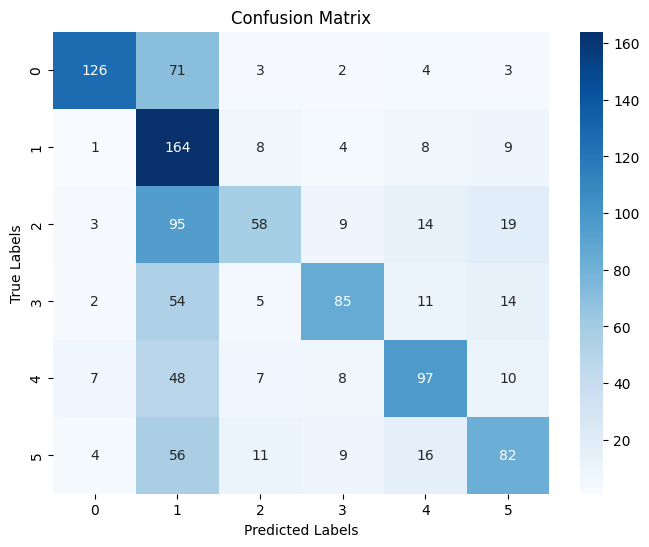

In [ ]:
# Tính confusion matrix
cm = confusion_matrix(y_test_RF, y_pred_rf)

# Hiển thị confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(numclasses), yticklabels=range(numclasses))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from joblib import dump

dump(rf_model, "/content/drive/MyDrive/dltest/doantotnghiep/model/rf_model.pkl")

['/content/drive/MyDrive/dltest/doantotnghiep/model/rf_model.pkl']

#Phương pháp 2: Dùng Pose Estimation(Mediapipe) & SVM

In [ ]:
# Tách đặc trưng và nhãn
columns_to_drop = ['video_name','Framecount', 'fourier_0', 'fourier_1', 'fourier_2', 'fourier_3', 'fourier_4', 'fourier_5', 'fourier_6', 'fourier_7', 'fourier_8', 'fourier_9', 'label', 'optical_mag_mean', 'optical_mag_max', 'optical_mag_var', 'optical_ang_mean', 'optical_ang_var']
X_SVM = df_balanced.drop(columns=columns_to_drop, axis=1).values
y_SVM = df_balanced['label']



label_encoder = LabelEncoder()
y_SVM = label_encoder.fit_transform(y_SVM)


print((X_SVM.shape[0]))
print(X_SVM.shape[1])


5634
99


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_SVM, y_SVM, test_size=0.2, random_state=42)

In [ ]:
# Khởi tạo mô hình SVM với kernel RBF
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Huấn luyện mô hình
svm_model.fit(X_train_SVM, y_train_SVM)

# Dự đoán và đánh giá mô hình
y_pred = svm_model.predict(X_test_SVM)
print("SVM Classification Report:")
print(classification_report(y_test_SVM, y_pred))
print(f"SVM Accuracy: {accuracy_score(y_test_SVM, y_pred)}")

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.46      0.56       209
           1       0.28      0.80      0.41       194
           2       0.25      0.08      0.12       198
           3       0.45      0.36      0.40       171
           4       0.42      0.23      0.29       177
           5       0.41      0.34      0.37       178

    accuracy                           0.38      1127
   macro avg       0.42      0.38      0.36      1127
weighted avg       0.42      0.38      0.36      1127

SVM Accuracy: 0.3797692990239574


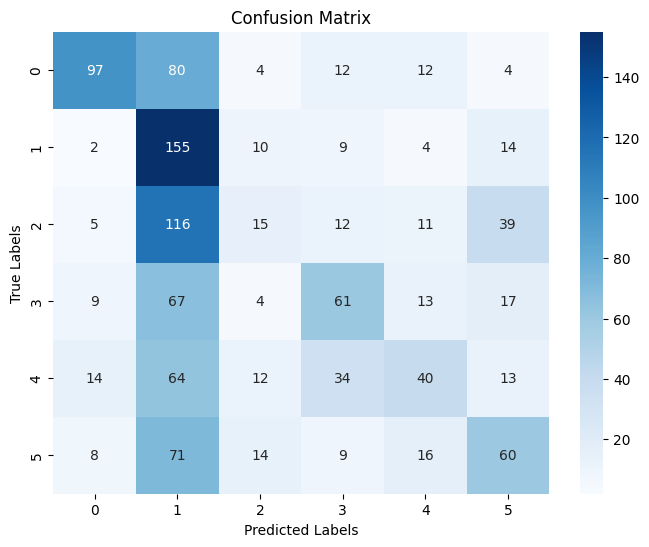

In [ ]:
# Tính confusion matrix
cm = confusion_matrix(y_test_SVM, y_pred)

# Hiển thị confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(numclasses), yticklabels=range(numclasses))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test_SVM, y_pred)*100
print(mape)

132.9192546583851


In [ ]:
from joblib import dump

dump(svm_model, "/content/drive/MyDrive/dltest/doantotnghiep/model/svm_model.pkl")

['/content/drive/MyDrive/dltest/doantotnghiep/model/svm_model.pkl']

#Phương pháp 3: All feature vs CNN

In [ ]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler,LabelEncoder

columns_to_drop = ['video_name','Framecount', 'label']
X_CNN = df_balanced.drop(columns=columns_to_drop, axis=1).values
y_CNN= df_balanced['label'].values




# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled_CNN = scaler.fit_transform(X_CNN)

# Reshape dữ liệu thành dạng (samples, time_steps, features)
X_reshaped = X_scaled_CNN.reshape(X_scaled_CNN.shape[0], 1, X_scaled_CNN.shape[1])  # CNN 1D



# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train_cnn, X_dem_cnn, y_train_cnn, y_dem_cnn = train_test_split(X_reshaped, y_CNN, test_size=0.2, random_state=42, stratify=y_CNN)
X_test_cnn, X_val_cnn, y_test_cnn, y_val_cnn = train_test_split(X_dem_cnn, y_dem_cnn, test_size=0.5, random_state=42,stratify=y_dem_cnn)


In [ ]:
X_scaled_CNN.shape[0] // 18

313

In [ ]:
print(X_train_cnn.shape)
print(X_test_cnn.shape)
print(y_train_cnn.shape)
print(y_test_cnn.shape)
print(X_val_cnn.shape)
print(y_val_cnn.shape)

(4507, 1, 114)
(563, 1, 114)
(4507,)
(563,)
(564, 1, 114)
(564,)


In [ ]:
cnn_model = models.Sequential([
    layers.Conv1D(128, kernel_size=1, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=1),

    layers.Conv1D(64, kernel_size=1, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=1),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(set(y_train_cnn)), activation='softmax')  # Output layer
])



cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Huấn luyện mô hình
History = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))

# Đánh giá mô hình
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"CNN Accuracy: {cnn_accuracy}")
print(f"CNN loss: {cnn_loss}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2728 - loss: 2.6461 - val_accuracy: 0.4007 - val_loss: 2.1241
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3971 - loss: 2.0588 - val_accuracy: 0.4468 - val_loss: 1.8396
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4476 - loss: 1.8135 - val_accuracy: 0.4787 - val_loss: 1.6525
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4795 - loss: 1.6250 - val_accuracy: 0.5195 - val_loss: 1.5197
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4997 - loss: 1.5081 - val_accuracy: 0.4929 - val_loss: 1.4458
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5155 - loss: 1.4048 - val_accuracy: 0.5177 - val_loss: 1.3817
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5366 - loss: 1.3447 - val_accuracy: 0.5266 - val_loss: 1.3271
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5677 - loss: 1.2577 - val_accuracy: 0.5443 - val_

In [ ]:
cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 1, 128)              │          14,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 1, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,748 (381.83 KB)

 Trainable params: 32,454 (126.77 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 64,910 (253.56 KB)

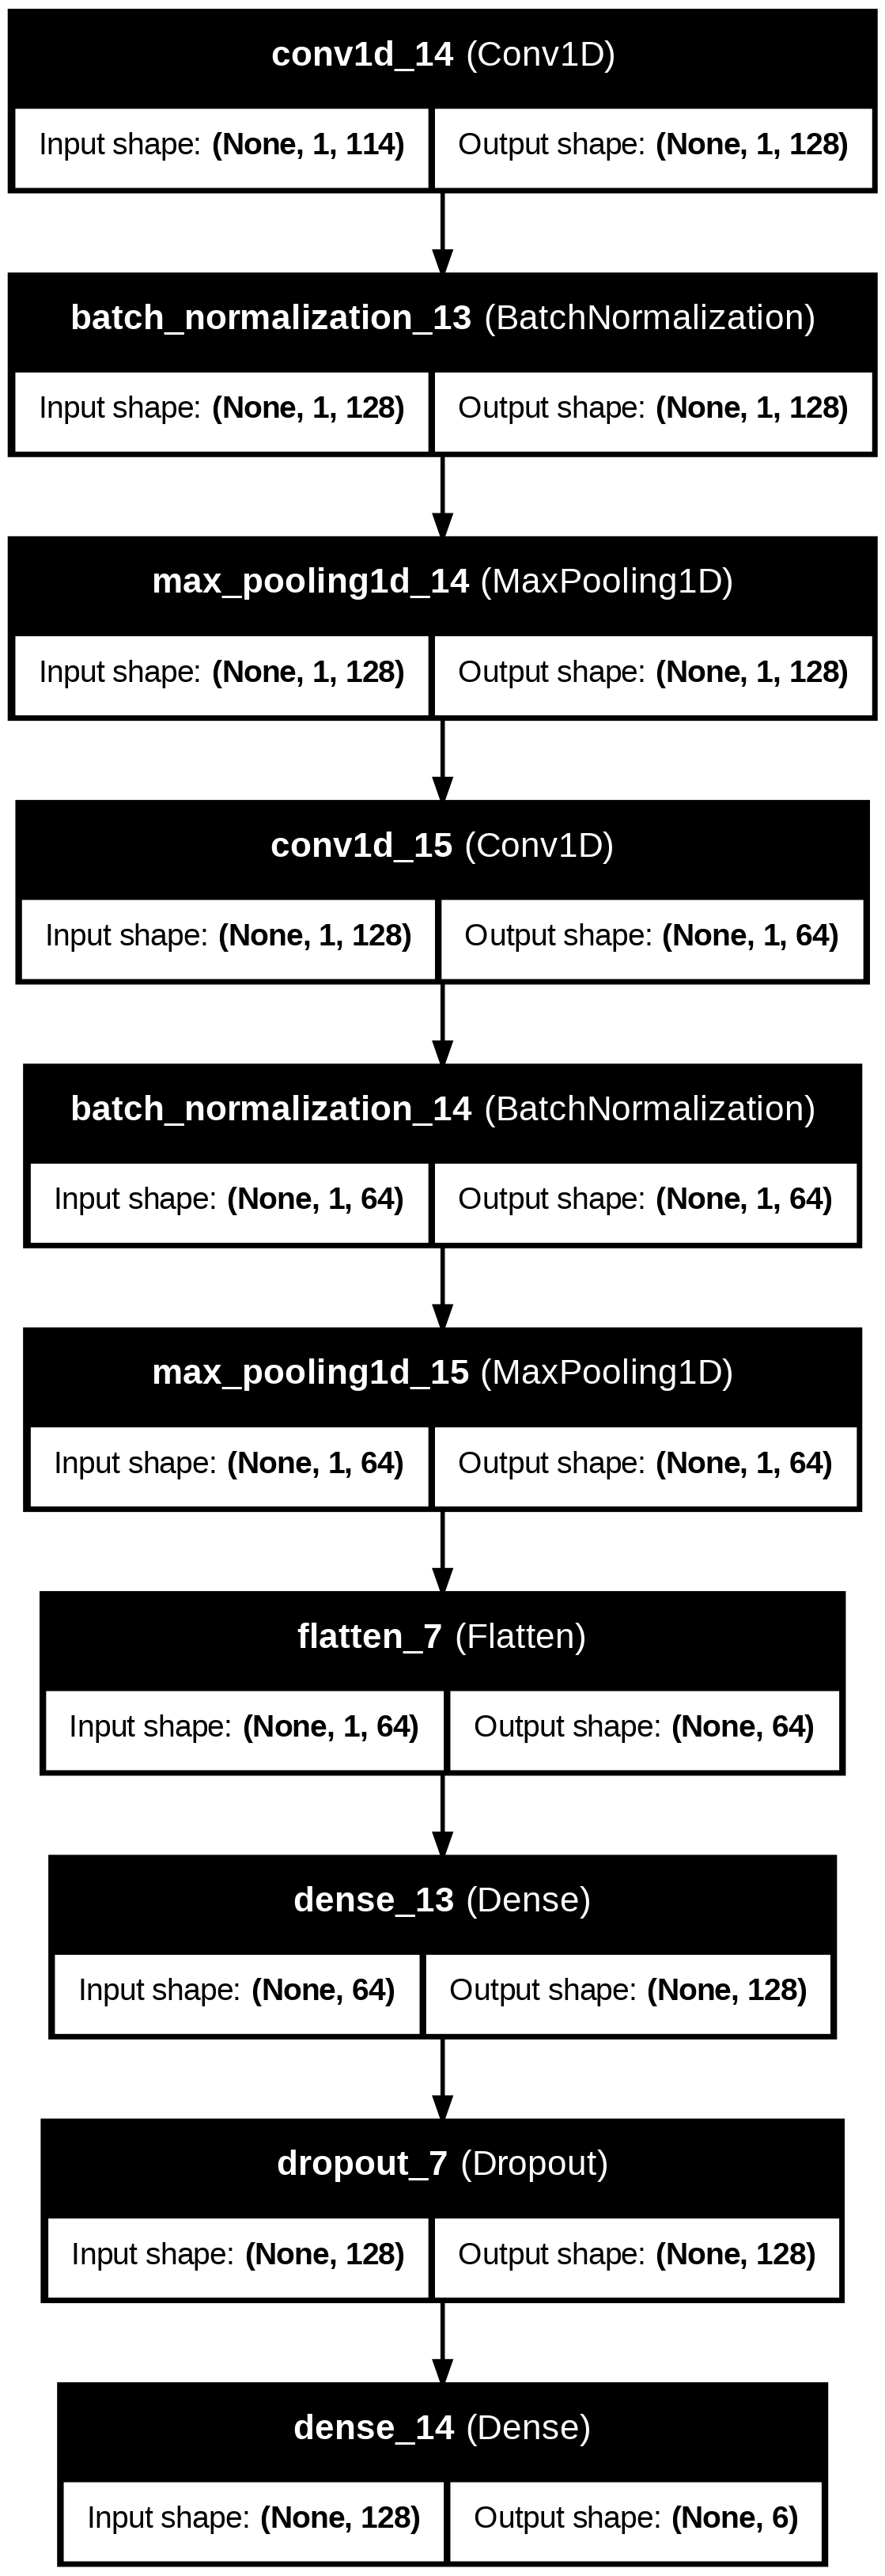

In [ ]:
from tensorflow.keras.utils import plot_model # Import the plot_model function
plot_model(cnn_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Hiển thị hình ảnh vừa lưu (tuỳ chọn)
from IPython.display import Image
Image('model_architecture.png')

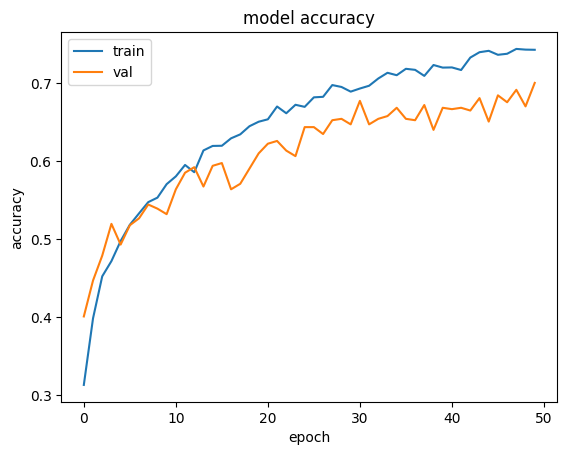

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

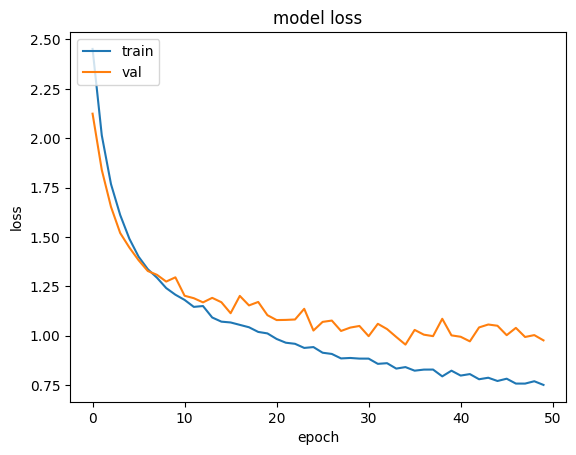

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Xuất mô hình CNN
cnn_model.save("/content/drive/MyDrive/dltest/doantotnghiep/model/cnn_model.h5")  # Lưu toàn bộ mô hình dưới dạng file HDF5
# Hoặc lưu dưới dạng SavedModel
cnn_model.save("/content/drive/MyDrive/dltest/doantotnghiep/model/cnn_model.keras")

#Phương pháp 4: All features vs CNN => LSTM

In [ ]:
cnn_lstm_model = models.Sequential([

    layers.Conv1D(128, kernel_size=1, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    layers.MaxPooling1D(pool_size=1),
    layers.BatchNormalization(),
    layers.Conv1D(60, kernel_size=1, activation='relu'),
    layers.MaxPooling1D(pool_size=1),

    # Flatten CNN features
    layers.Flatten(),

    # Reshape for LSTM
    layers.Reshape((-1, 60)),  # Adjust based on output of CNN block
    layers.Bidirectional(layers.LSTM(60, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(60, return_sequences=False)),

    # Fully Connected Layers
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(set(y_train_cnn)), activation='softmax')  # Output layer
])

cnn_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Huấn luyện mô hình
History2 = cnn_lstm_model.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))

# Đánh giá mô hình
cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test_cnn, y_test_cnn)
print(f"CNN Accuracy: {cnn_lstm_accuracy}")
print(f"CNN loss: {cnn_lstm_loss}")

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.2509 - loss: 2.4424 - val_accuracy: 0.3954 - val_loss: 1.6397
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4017 - loss: 1.5738 - val_accuracy: 0.4734 - val_loss: 1.4324
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4637 - loss: 1.4158 - val_accuracy: 0.4415 - val_loss: 1.4171
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5003 - loss: 1.3375 - val_accuracy: 0.5124 - val_loss: 1.3392
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5065 - loss: 1.3262 - val_accuracy: 0.4965 - val_loss: 1.3187
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5374 - loss: 1.2472 - val_accuracy: 0.5053 - val_loss: 1.2774
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5731 - loss: 1.1716 - val_accuracy: 0.5638 - val_loss: 1.1973
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5772 - loss: 1.1594 - val_accurac

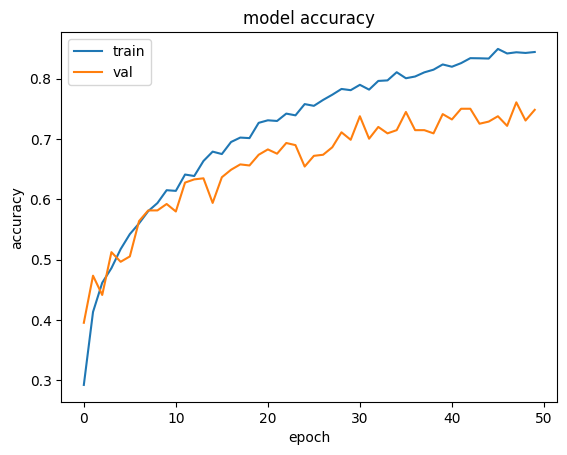

In [ ]:
plt.plot(History2.history['accuracy'])
plt.plot(History2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

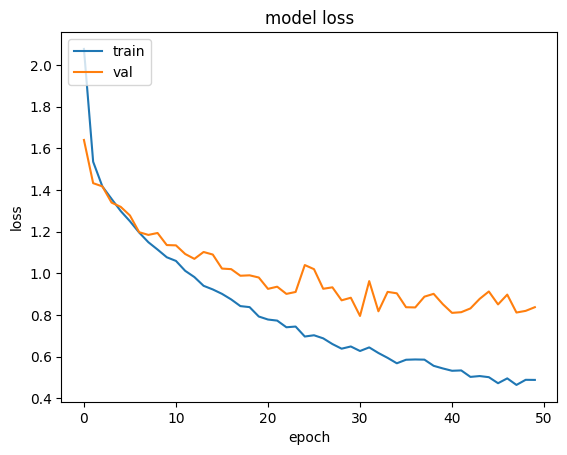

In [ ]:
plt.plot(History2.history['loss'])
plt.plot(History2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 1, 128)              │          14,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 1, 60)               │           7,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 1, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 120)              │          58,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          15,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 552,072 (2.11 MB)

 Trainable params: 183,938 (718.51 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 367,878 (1.40 MB)

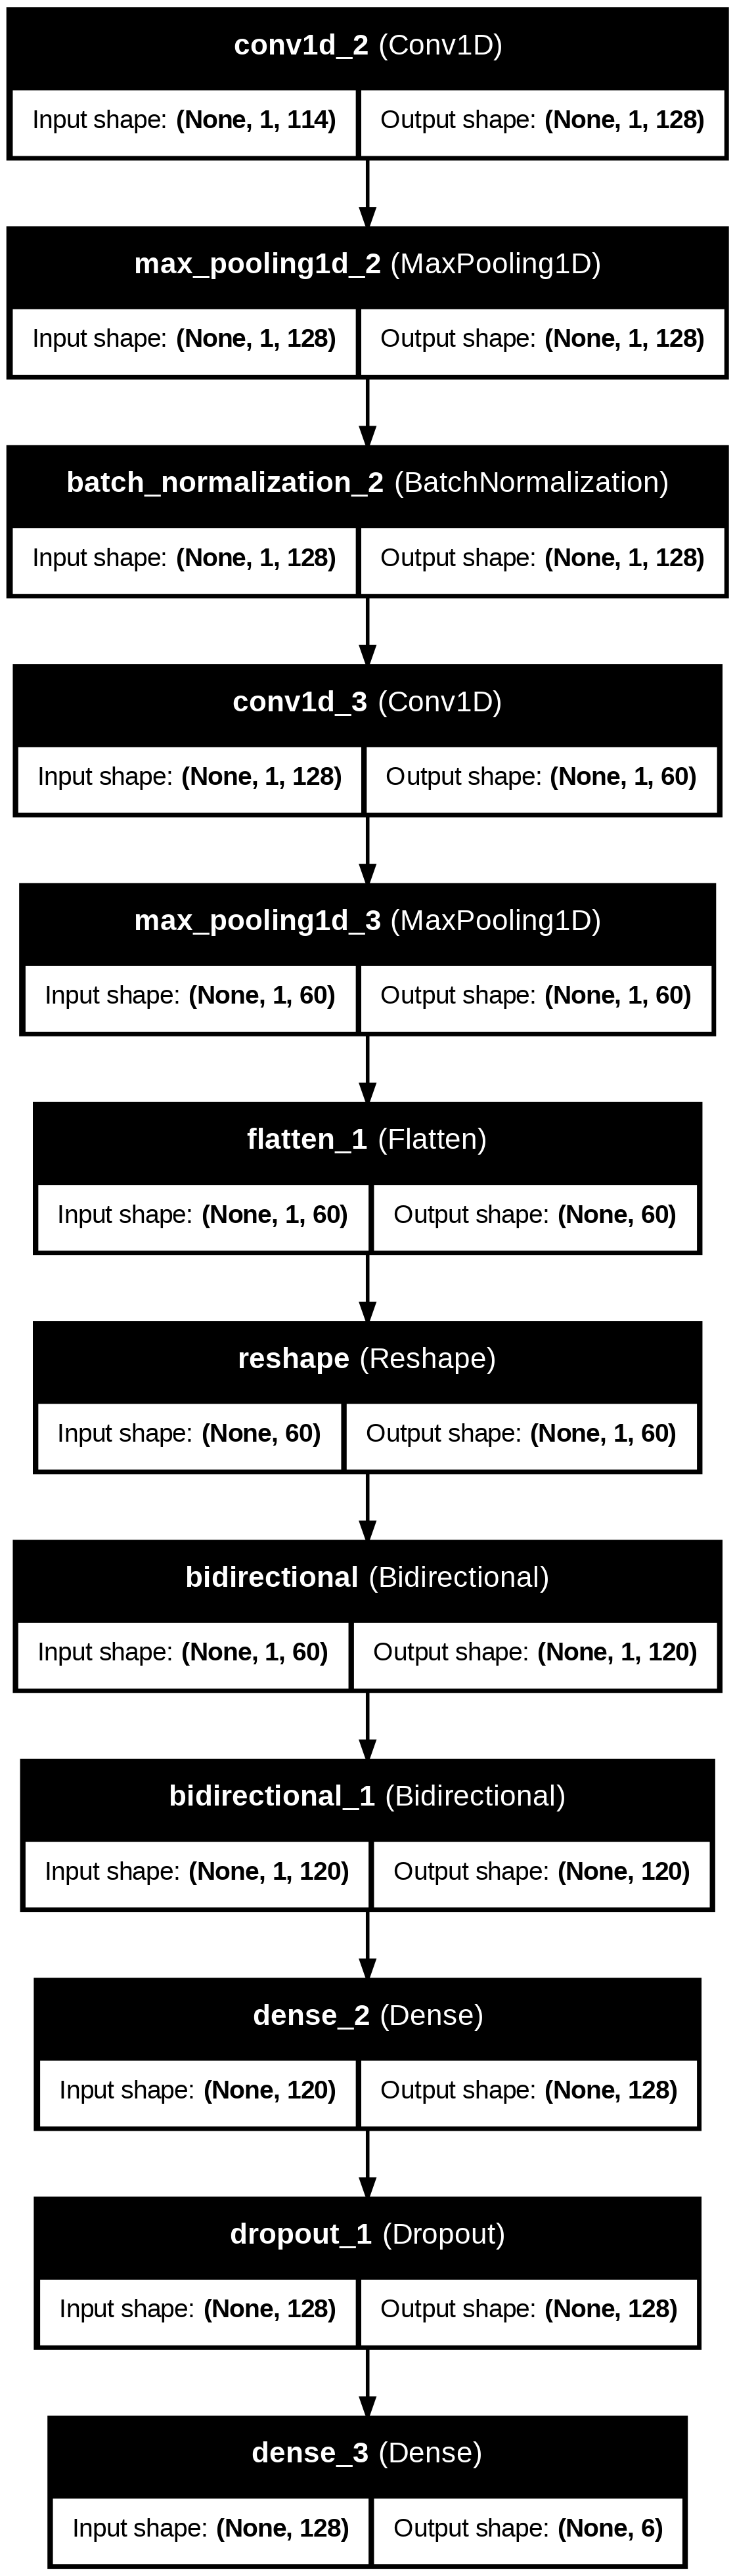

In [ ]:
plot_model(cnn_lstm_model, to_file='model_architecture2.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Xuất mô hình CNN
cnn_lstm_model.save("/content/drive/MyDrive/dltest/doantotnghiep/model/cnn_lstm_model.h5")  # Lưu toàn bộ mô hình dưới dạng file HDF5
# Hoặc lưu dưới dạng SavedModel
cnn_lstm_model.save("/content/drive/MyDrive/dltest/doantotnghiep/model/cnn_lstm_model.keras")